In [1]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 18.5 MB/s eta 0:00:0000:0100:01


In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms, models
from PIL import Image
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pycocoevalcap

## Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data loading and preprocessing

In [4]:
def load_captions(captions_path):
    """Load captions from CSV file"""
    captions = {}
    with open(captions_path, 'r') as f:
        next(f)  # skip header line
        for line in f:
            line = line.strip()
            if not line:
                continue
            img, caption = line.split(',', 1)
            captions.setdefault(img, []).append(caption.lower())
    return captions


In [5]:
def tokenize(text):
    """Simple tokenizer"""
    return text.lower().strip().split()

In [6]:
class Vocabulary:
    """Build vocabulary from captions"""
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {
            "<PAD>": 0,
            "<SOS>": 1,
            "<EOS>": 2,
            "<UNK>": 3
        }
        self.idx2word = {v: k for k, v in self.word2idx.items()}

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in tokenize(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word
                    idx += 1

    def numericalize(self, text):
        return [
            self.word2idx.get(word, self.word2idx["<UNK>"])
            for word in tokenize(text)
        ]

    def __len__(self):
        return len(self.word2idx)


## Dataset Class

In [7]:
class FlickrDataset(Dataset):
    def __init__(self, image_dir, captions, vocab, transform=None):
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform
        
        # Store all image-caption pairs
        self.data = []
        for img_name, caption_list in captions.items():
            for caption in caption_list:  # Use ALL captions
                self.data.append((img_name, caption))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, caption = self.data[idx]
        
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        numericalized_caption = (
            [self.vocab.word2idx["<SOS>"]] +
            self.vocab.numericalize(caption) +
            [self.vocab.word2idx["<EOS>"]]
        )

        return image, torch.tensor(numericalized_caption)

In [8]:
def collate_fn(batch):
    """Custom collate function for DataLoader"""
    images = []
    captions = []

    for img, cap in batch:
        images.append(img)
        captions.append(cap)

    images = torch.stack(images)
    captions = pad_sequence(captions, batch_first=True, padding_value=0)

    return images, captions

## Model Architecture

#### Encoder enhancment too, can choose from main function

In [9]:
class EncoderCNN(nn.Module):
    """CNN Encoder using pretrained ResNet50"""
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Freeze ResNet parameters
        for param in resnet.parameters():
            param.requires_grad = False
        
        # Remove final classification layer
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        
        # Custom FC layer with regularization
        self.fc = nn.Sequential(
            nn.Linear(resnet.fc.in_features, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.Dropout(0.5)
        )

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return features


In [10]:
class SpatialEncoderCNN(nn.Module):
    """Encoder that outputs spatial feature maps for better attention"""
    def __init__(self, encoded_image_size=14):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Remove last layers (keep conv features)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Freeze
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Adaptive pool to fixed spatial size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        
        self.encoded_image_size = encoded_image_size
        
    def forward(self, images):
        with torch.no_grad():
            out = self.resnet(images)  # (batch, 2048, h, w)
        out = self.adaptive_pool(out)  # (batch, 2048, 14, 14)
        
        # Flatten spatial dimensions: (batch, 2048, 14*14) -> (batch, 196, 2048)
        batch_size = out.size(0)
        out = out.permute(0, 2, 3, 1)  # (batch, 14, 14, 2048)
        out = out.view(batch_size, -1, 2048)  # (batch, 196, 2048)
        
        return out

#### This is version 1 but now i am using attention decoder (you can change that from main)

In [11]:
class DecoderRNN(nn.Module):
    """LSTM Decoder for caption generation"""
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2):
        super().__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(
            embed_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=0.5 if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        outputs, _ = self.lstm(embeddings)
        outputs = self.fc(outputs)
        return outputs
    
    def generate_caption(self, features, vocab, max_length=20):
        """Generate caption using greedy search"""
        result = []
        states = None
        inputs = features.unsqueeze(1)
        
        for _ in range(max_length):
            outputs, states = self.lstm(inputs, states)
            outputs = self.fc(outputs.squeeze(1))
            predicted = outputs.argmax(1)
            result.append(predicted.item())
            
            if predicted.item() == vocab.word2idx["<EOS>"]:
                break
                
            inputs = self.embed(predicted).unsqueeze(1)
        
        return result
    
    def generate_caption_beam(self, features, vocab, beam_width=3, max_length=20):
        """Generate caption using beam search"""
        k = beam_width
        
        # Start with <SOS> token
        sequences = [[vocab.word2idx["<SOS>"]]]
        scores = [0.0]
        states_list = [None]
        
        for step in range(max_length):
            all_candidates = []
            
            for i, seq in enumerate(sequences):
                if seq[-1] == vocab.word2idx["<EOS>"]:
                    all_candidates.append((scores[i], seq, states_list[i]))
                    continue
                
                # Get input
                if step == 0:
                    inputs = features.unsqueeze(1)
                else:
                    inputs = self.embed(torch.tensor([seq[-1]]).to(features.device)).unsqueeze(1)
                
                # Forward pass
                outputs, states = self.lstm(inputs, states_list[i])
                outputs = self.fc(outputs.squeeze(1))
                log_probs = torch.log_softmax(outputs, dim=1)
                
                # Get top k predictions
                topk_probs, topk_indices = log_probs.topk(k, dim=1)
                
                for j in range(k):
                    candidate_seq = seq + [topk_indices[0][j].item()]
                    candidate_score = scores[i] + topk_probs[0][j].item()
                    all_candidates.append((candidate_score, candidate_seq, states))
            
            # Select top k sequences
            ordered = sorted(all_candidates, key=lambda x: x[0], reverse=True)
            sequences = [seq for score, seq, states in ordered[:k]]
            scores = [score for score, seq, states in ordered[:k]]
            states_list = [states for score, seq, states in ordered[:k]]
            
            # Check if all sequences have ended
            if all(seq[-1] == vocab.word2idx["<EOS>"] for seq in sequences):
                break
        
        # Return best sequence
        best_seq = sequences[0][1:]  # Skip <SOS>
        if best_seq and best_seq[-1] == vocab.word2idx["<EOS>"]:
            best_seq = best_seq[:-1]  # Remove <EOS>
        return best_seq

In [12]:
class AdvancedAttentionDecoder(nn.Module):
    """Decoder with proper spatial attention over image regions"""
    def __init__(self, embed_size, hidden_size, vocab_size, encoder_dim=2048, num_layers=1):
        super().__init__()
        
        self.encoder_dim = encoder_dim
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        
        # Embedding
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # Attention network
        self.attention = nn.Linear(encoder_dim + hidden_size, 1)
        
        # LSTM cell (using LSTMCell for step-by-step processing)
        self.decode_step = nn.LSTMCell(embed_size + encoder_dim, hidden_size)
        
        # Linear layers
        self.init_h = nn.Linear(encoder_dim, hidden_size)
        self.init_c = nn.Linear(encoder_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, encoder_out, captions):
        """
        encoder_out: (batch, num_pixels, encoder_dim) e.g., (batch, 196, 2048)
        captions: (batch, seq_len)
        """
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.fc.out_features
        
        # Flatten image
        num_pixels = encoder_out.size(1)
        
        # Get embeddings
        embeddings = self.embed(captions)  # (batch, seq_len, embed_size)
        
        # Initialize LSTM state
        mean_encoder_out = encoder_out.mean(dim=1)  # (batch, encoder_dim)
        h = self.init_h(mean_encoder_out)  # (batch, hidden_size)
        c = self.init_c(mean_encoder_out)  # (batch, hidden_size)
        
        seq_len = captions.size(1)
        predictions = torch.zeros(batch_size, seq_len, vocab_size).to(encoder_out.device)
        
        for t in range(seq_len):
            # Attention
            attention_input = torch.cat([
                encoder_out,  # (batch, num_pixels, encoder_dim)
                h.unsqueeze(1).expand(-1, num_pixels, -1)  # (batch, num_pixels, hidden_size)
            ], dim=2)  # (batch, num_pixels, encoder_dim + hidden_size)
            
            attention_scores = self.attention(attention_input).squeeze(2)  # (batch, num_pixels)
            alpha = torch.softmax(attention_scores, dim=1)  # (batch, num_pixels)
            
            # Context vector
            context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch, encoder_dim)
            
            # LSTM step
            lstm_input = torch.cat([embeddings[:, t, :], context], dim=1)
            h, c = self.decode_step(lstm_input, (h, c))
            
            # Prediction
            preds = self.fc(self.dropout(h))
            predictions[:, t, :] = preds
        
        return predictions
    
    def generate_caption_beam(self, encoder_out, vocab, beam_width=5, max_length=20):
        """Beam search with spatial attention"""
        k = beam_width
        batch_size = encoder_out.size(0)
        num_pixels = encoder_out.size(1)
        encoder_dim = encoder_out.size(-1)
        
        # Expand encoder output for beam search
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)
        
        # Initialize
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        
        # Start sequences
        seqs = torch.tensor([[vocab.word2idx["<SOS>"]]] * k).to(encoder_out.device)
        top_k_scores = torch.zeros(k, 1).to(encoder_out.device)
        
        complete_seqs = []
        complete_seqs_scores = []
        
        for step in range(max_length):
            embeddings = self.embed(seqs[:, -1])
            
            # Attention
            attention_input = torch.cat([encoder_out, h.unsqueeze(1).expand(-1, num_pixels, -1)], dim=2)
            attention_scores = self.attention(attention_input).squeeze(2)
            alpha = torch.softmax(attention_scores, dim=1)
            context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
            
            # LSTM
            lstm_input = torch.cat([embeddings, context], dim=1)
            h, c = self.decode_step(lstm_input, (h, c))
            
            # Scores
            scores = self.fc(h)
            scores = torch.log_softmax(scores, dim=1)
            
            scores = top_k_scores.expand_as(scores) + scores
            
            if step == 0:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
            else:
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)
            
            prev_word_inds = top_k_words // self.fc.out_features
            next_word_inds = top_k_words % self.fc.out_features
            
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)
            
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) 
                              if next_word != vocab.word2idx["<EOS>"]]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
            
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            
            k -= len(complete_inds)
            if k == 0:
                break
            
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        
        if len(complete_seqs) > 0:
            i = complete_seqs_scores.index(max(complete_seqs_scores))
            seq = complete_seqs[i]
        else:
            seq = seqs[0].tolist()
        
        # Remove special tokens
        seq = [idx for idx in seq[1:] if idx not in [vocab.word2idx["<SOS>"], 
                                                      vocab.word2idx["<EOS>"], 
                                                      vocab.word2idx["<PAD>"]]]
        return seq

## Trainindg def

In [13]:
def train_model(encoder, decoder, train_loader, val_loader, criterion, optimizer, 
                num_epochs, device, save_path="best_model.pth"):
    """Train the model with validation"""
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2
    )
    
    for epoch in range(num_epochs):
        # --- TRAINING ---
        encoder.train()
        decoder.train()
        total_train_loss = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, captions in train_bar:
            images, captions = images.to(device), captions.to(device)
            
            optimizer.zero_grad()
            features = encoder(images)
            outputs = decoder(features, captions[:, :-1])
            
            # loss = criterion(
            #     outputs.reshape(-1, outputs.shape[2]), 
            #     captions.reshape(-1)
            # )

            # Replace the existing criterion block with this:
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]),  # Predictions: [Batch * (Seq_Len-1), Vocab_Size]
                captions[:, 1:].contiguous().view(-1)   # Targets: [Batch * (Seq_Len-1)]
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=5)
            optimizer.step()
            
            total_train_loss += loss.item()
            train_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # --- VALIDATION ---
        encoder.eval()
        decoder.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for images, captions in val_loader:
                images, captions = images.to(device), captions.to(device)
                features = encoder(images)
                outputs = decoder(features, captions[:, :-1])
                # enk dekod
                # loss = criterion(
                #     outputs.reshape(-1, outputs.shape[2]), 
                #     captions.reshape(-1)
                # )

                loss = criterion(
                    outputs.reshape(-1, outputs.shape[2]),  # Predictions: [Batch * (Seq_Len-1), Vocab_Size]
                    captions[:, 1:].contiguous().view(-1)   # Targets: [Batch * (Seq_Len-1)]
                )
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Update learning rate and track changes
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if new_lr != old_lr:
            print(f"Learning rate reduced: {old_lr:.2e} → {new_lr:.2e}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, save_path)
            print(f"✓ Saved best model (val_loss: {best_val_loss:.4f})")
        
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    return train_losses, val_losses

## inference functions

In [14]:
def generate_caption(image_path, encoder, decoder, vocab, transform, device, beam_search=True):
    """Generate caption for a single image"""
    encoder.eval()
    decoder.eval()
    
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = encoder(image)
        if beam_search:
            caption_indices = decoder.generate_caption_beam(features, vocab)
        else:
            caption_indices = decoder.generate_caption(features, vocab)
    
    caption = ' '.join([vocab.idx2word.get(idx, '<UNK>') for idx in caption_indices])
    return caption

In [15]:
def visualize_predictions_full(encoder, decoder, dataset, vocab, device, num_samples=5):
    """Visualize predictions on sample images with full captions (no truncation, no wrap)"""
    encoder.eval()
    decoder.eval()
    
    fig, axes = plt.subplots(1, num_samples, figsize=(6*num_samples, 6))
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        idx = torch.randint(0, len(dataset), (1,)).item()
        image, true_caption_idx = dataset[idx]
        
        with torch.no_grad():
            features = encoder(image.unsqueeze(0).to(device))
            # Replace with your generate_caption function
            pred_caption_idx = decoder.generate_caption_beam(features, vocab)
        
        # Convert indices to text
        true_caption = ' '.join([vocab.idx2word.get(idx, '<UNK>') 
                                 for idx in true_caption_idx.tolist()[1:-1]])
        pred_caption = ' '.join([vocab.idx2word.get(idx, '<UNK>') 
                                for idx in pred_caption_idx 
                                if idx not in [vocab.word2idx['<SOS>'], 
                                               vocab.word2idx['<EOS>'], 
                                               vocab.word2idx['<PAD>']]])
        
        # Denormalize image
        img = image.permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_caption}\nPred: {pred_caption}", fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [16]:
def plot_losses(train_losses, val_losses):
    """Plot training and validation losses"""
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-s', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [17]:
def evaluate_on_test(encoder, decoder, test_loader, criterion, device):
    """Evaluate model on test set"""
    encoder.eval()
    decoder.eval()
    total_loss = 0
    
    print("\nEvaluating on test set...")
    with torch.no_grad():
        for images, captions in tqdm(test_loader, desc="Testing"):
            images, captions = images.to(device), captions.to(device)
            features = encoder(images)
            outputs = decoder(features, captions[:, :-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), 
                captions[:, 1:].contiguous().view(-1)
            )
            total_loss += loss.item()
    
    avg_test_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")
    return avg_test_loss

In [18]:
def calculate_cider_score(
    encoder,
    decoder,
    test_dataset,
    vocab,
    device,
    num_samples=100
):
    """
    Calculate CIDEr score on test set
    """
    from pycocoevalcap.cider.cider import Cider
    from tqdm import tqdm
    import torch

    encoder.eval()
    decoder.eval()

    # CIDEr expects dicts: {id: [caption]}
    gts = {}   # ground truth
    res = {}   # predictions

    print(f"\nCalculating CIDEr score on {num_samples} samples...")

    for i in tqdm(range(min(num_samples, len(test_dataset)))):
        image, true_caption_idx = test_dataset[i]

        # Generate caption
        with torch.no_grad():
            features = encoder(image.unsqueeze(0).to(device))
            pred_caption_idx = decoder.generate_caption_beam(features, vocab)

        # Convert GT to words
        true_words = [
            vocab.idx2word.get(idx, '<UNK>')
            for idx in true_caption_idx.tolist()
            if idx not in (
                vocab.word2idx.get('<SOS>'),
                vocab.word2idx.get('<EOS>'),
                vocab.word2idx.get('<PAD>')
            )
        ]

        # Convert prediction to words
        pred_words = [
            vocab.idx2word.get(idx, '<UNK>')
            for idx in pred_caption_idx
            if idx not in (
                vocab.word2idx.get('<EOS>'),
                vocab.word2idx.get('<PAD>')
            )
        ]

        # CIDEr wants strings
        gts[i] = [" ".join(true_words)]
        res[i] = [" ".join(pred_words)]

    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(gts, res)

    print(f"CIDEr Score: {cider_score:.4f}")
    return cider_score


# Execution

In [19]:
captions_path = "/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt"
image_dir = "/kaggle/input/flickr8kimagescaptions/flickr8k/images"

In [20]:
embed_size = 256
hidden_size = 512
num_layers = 1        # advancedAttention radgan gvaqvs num_layers must be 1
batch_size = 32
num_epochs = 30
learning_rate = 1e-4
encoder_dim = 2048 


In [21]:
captions = load_captions(captions_path)
print(f"Loaded {len(captions)} images with captions")

Loaded 8091 images with captions


In [22]:
vocab = Vocabulary(freq_threshold=5)
all_captions = [cap for caps in captions.values() for cap in caps]
vocab.build_vocab(all_captions)
vocab_size = len(vocab.word2idx)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 3040


In [23]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [24]:
full_dataset = FlickrDataset(image_dir, captions, vocab, train_transform)


In [25]:
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

In [26]:
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform    

In [27]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, 
    collate_fn=collate_fn, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fn, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fn, num_workers=2
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 32364
Validation samples: 4045
Test samples: 4046


In [28]:
encoder = SpatialEncoderCNN(encoded_image_size=14).to(device)
decoder = AdvancedAttentionDecoder(
    embed_size=256,
    hidden_size=512,
    vocab_size=vocab_size,
    encoder_dim=2048
).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s] 


In [29]:
# ეს ჩვეულებრივი ენკოდერის და დეკოდერისთვის
criterion = nn.CrossEntropyLoss(ignore_index=0)
# optimizer = optim.Adam(
#     list(encoder.fc.parameters()) + list(decoder.parameters()),
#     lr=learning_rate,
#     weight_decay=1e-5
# )

optimizer = optim.Adam(
    decoder.parameters(),  # Only decoder parameters (encoder is frozen)
    lr=learning_rate,
    weight_decay=1e-5
)

In [30]:
print(f"Encoder parameters: {sum(p.numel() for p in encoder.parameters() if p.requires_grad):,}")
print(f"Decoder parameters: {sum(p.numel() for p in decoder.parameters() if p.requires_grad):,}")    

Encoder parameters: 0
Decoder parameters: 10,209,761


## Training start

In [ ]:
train_losses, val_losses = train_model(
    encoder, decoder, train_loader, val_loader,
    criterion, optimizer, num_epochs, device,
    save_path="best_caption_model.pth"
)

Epoch 1/30 [Train]: 100%|██████████| 1012/1012 [03:36<00:00,  4.69it/s, loss=3.82]


✓ Saved best model (val_loss: 3.7366)
Epoch [1/30] Train Loss: 4.3576 | Val Loss: 3.7366


Epoch 2/30 [Train]: 100%|██████████| 1012/1012 [03:40<00:00,  4.59it/s, loss=3.57]


✓ Saved best model (val_loss: 3.4006)
Epoch [2/30] Train Loss: 3.6473 | Val Loss: 3.4006


Epoch 3/30 [Train]: 100%|██████████| 1012/1012 [03:42<00:00,  4.55it/s, loss=2.97]


✓ Saved best model (val_loss: 3.2011)
Epoch [3/30] Train Loss: 3.3798 | Val Loss: 3.2011


Epoch 4/30 [Train]: 100%|██████████| 1012/1012 [03:43<00:00,  4.53it/s, loss=3.38]


✓ Saved best model (val_loss: 3.0632)
Epoch [4/30] Train Loss: 3.2042 | Val Loss: 3.0632


Epoch 5/30 [Train]: 100%|██████████| 1012/1012 [03:42<00:00,  4.54it/s, loss=3.37]


✓ Saved best model (val_loss: 2.9662)
Epoch [5/30] Train Loss: 3.0793 | Val Loss: 2.9662


Epoch 6/30 [Train]: 100%|██████████| 1012/1012 [03:42<00:00,  4.55it/s, loss=2.87]


✓ Saved best model (val_loss: 2.8905)
Epoch [6/30] Train Loss: 2.9797 | Val Loss: 2.8905


Epoch 7/30 [Train]: 100%|██████████| 1012/1012 [03:42<00:00,  4.55it/s, loss=2.54]


✓ Saved best model (val_loss: 2.8318)
Epoch [7/30] Train Loss: 2.8990 | Val Loss: 2.8318


Epoch 8/30 [Train]: 100%|██████████| 1012/1012 [03:43<00:00,  4.53it/s, loss=2.86]


✓ Saved best model (val_loss: 2.7807)
Epoch [8/30] Train Loss: 2.8322 | Val Loss: 2.7807


Epoch 9/30 [Train]: 100%|██████████| 1012/1012 [03:42<00:00,  4.54it/s, loss=2.56]


✓ Saved best model (val_loss: 2.7373)
Epoch [9/30] Train Loss: 2.7729 | Val Loss: 2.7373


Epoch 10/30 [Train]: 100%|██████████| 1012/1012 [03:42<00:00,  4.54it/s, loss=2.64]


✓ Saved best model (val_loss: 2.7007)
Epoch [10/30] Train Loss: 2.7222 | Val Loss: 2.7007


Epoch 11/30 [Train]:  49%|████▉     | 494/1012 [01:49<02:03,  4.20it/s, loss=2.75]

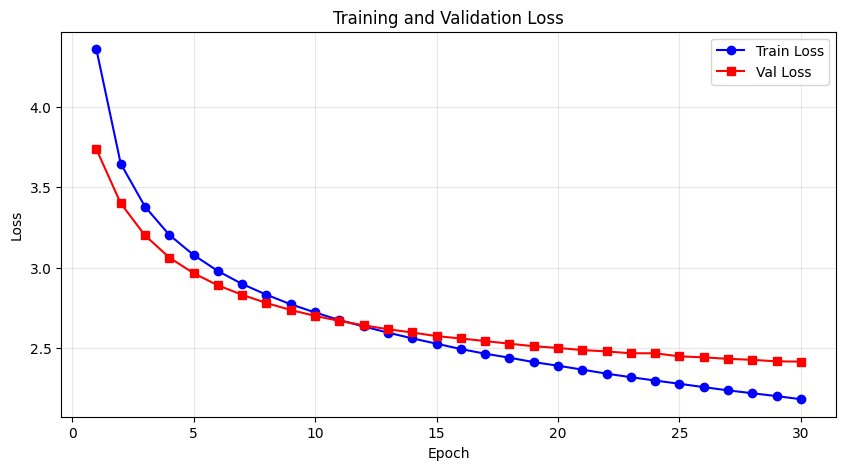

In [38]:
plot_losses(train_losses, val_losses)

In [39]:
    checkpoint = torch.load("best_caption_model.pth")
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    

<All keys matched successfully>

In [40]:
    test_loss = evaluate_on_test(encoder, decoder, test_loader, criterion, device)
 


Evaluating on test set...


Testing: 100%|██████████| 127/127 [00:18<00:00,  6.79it/s]

Test Loss: 2.4298


In [41]:
try:
    cider_score = calculate_cider_score(
        encoder,
        decoder,
        test_dataset,
        vocab,
        device,
        num_samples=100
    )
except ImportError:
    print("pycocoevalcap not installed. Skipping CIDEr score.")
    print("Install with: pip install pycocoevalcap")



Calculating CIDEr score on 100 samples...


100%|██████████| 100/100 [00:02<00:00, 33.88it/s]

CIDEr Score: 0.9635


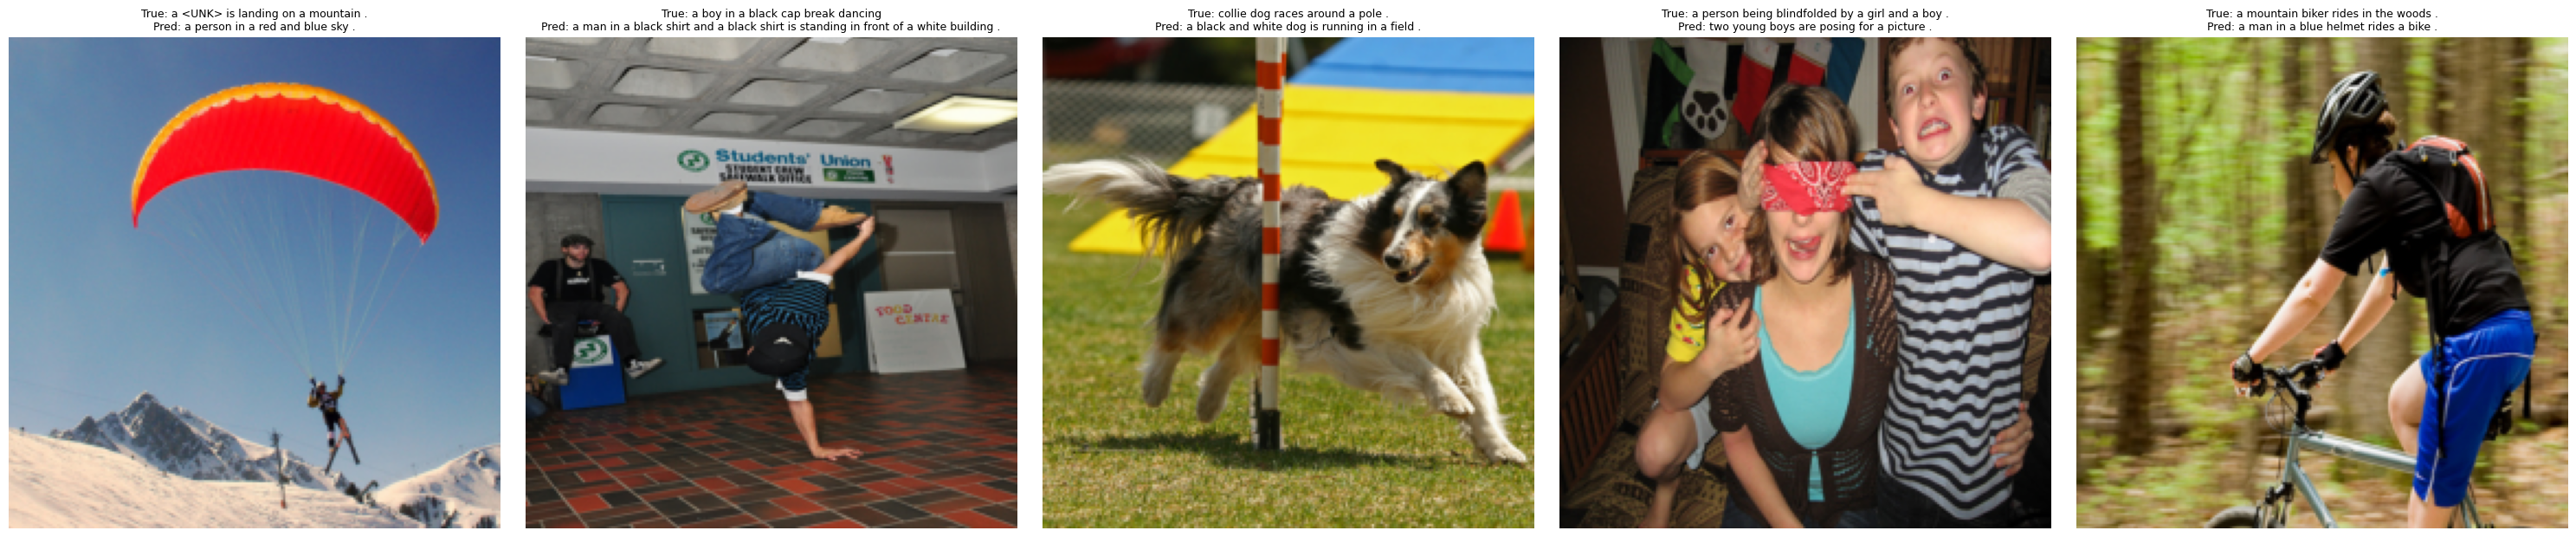

In [42]:
visualize_predictions_full(encoder, decoder, test_dataset, vocab, device, num_samples=5)

In [ ]:
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),

    'vocab': vocab.word2idx,
    'idx2word': vocab.idx2word,

    'pad_idx': vocab.word2idx['<pad>'],
    'start_idx': vocab.word2idx['<start>'],
    'end_idx': vocab.word2idx['<end>'],
    'unk_idx': vocab.word2idx['<unk>'],

    'embed_size': embed_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,

    'encoder_name': 'resnet50',
    'image_size': 224,
    'normalize_mean': [0.485, 0.456, 0.406],
    'normalize_std': [0.229, 0.224, 0.225],
}, "final_caption_model.pth")
